# Comparación de Métodos de Extracción PDF - Fuente CY

Este notebook permite comparar dos métodos de extracción de texto desde PDFs:

- **pdfplumber**: Extracción directa de texto plano
- **pymupdf4llm**: Conversión a formato Markdown con estructura semántica

## Objetivo

Determinar cuál método es más adecuado según:

1. Tiempo de procesamiento
2. Precisión de extracción de campos críticos
3. Estructura semántica y compatibilidad con LLMs
4. Facilidad de parsing con regex tradicional

## ⚠️ Nota Importante

La elección del método depende del **caso de uso**:

- **Parsing tradicional con regex**: pdfplumber puede ser más simple
- **Procesamiento con LLMs/IA**: pymupdf4llm ofrece mejor estructura semántica


## Paso 1: Instalación de Dependencias


In [ ]:
# Descomenta si necesitas instalar las dependencias
# !pip install pdfplumber pymupdf pymupdf4llm pandas matplotlib seaborn numpy

## Paso 2: Importar Librerías


In [1]:
import os
import time
import re
from pathlib import Path
from typing import Dict, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Librerías de extracción PDF
import pdfplumber
import fitz  # PyMuPDF
import pymupdf4llm

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## Paso 3: Configurar Rutas


In [2]:
# Configurar rutas
SOURCE_PATH = "D:/Usuarios/14624165/GitHub/TallerSpark/source=CY"  # Carpeta con PDFs fuente
OUTPUT_PATH = "comparacion_metodos_cy"  # Carpeta para resultados
SAMPLE_SIZE = 15  # Número de PDFs a procesar (ajusta según necesites)

# Crear directorio de salida si no existe
os.makedirs(OUTPUT_PATH, exist_ok=True)

print(f"📁 Carpeta fuente: {SOURCE_PATH}")
print(f"📁 Carpeta salida: {OUTPUT_PATH}")
print(f"📊 Tamaño de muestra: {SAMPLE_SIZE} PDFs")

📁 Carpeta fuente: D:/Usuarios/14624165/GitHub/TallerSpark/source=CY
📁 Carpeta salida: comparacion_metodos_cy
📊 Tamaño de muestra: 15 PDFs


## Paso 4: Obtener Lista de PDFs


In [3]:
# Obtener lista de PDFs
pdf_files = []
for root, _, files in os.walk(SOURCE_PATH):
    for file in files:
        if file.lower().endswith(".pdf"):
            pdf_files.append(os.path.join(root, file))

print(f"📄 Total de PDFs encontrados: {len(pdf_files)}")

# Seleccionar muestra aleatoria si hay más PDFs que el tamaño de muestra
if len(pdf_files) > SAMPLE_SIZE:
    import random
    random.seed(42)  # Para reproducibilidad
    pdf_files = random.sample(pdf_files, SAMPLE_SIZE)
    print(f"🎲 Seleccionados {SAMPLE_SIZE} PDFs aleatorios")

print(f"\n📋 Archivos a procesar:")
for i, pdf in enumerate(pdf_files[:5], 1):
    print(f"  {i}. {os.path.basename(pdf)}")
if len(pdf_files) > 5:
    print(f"  ... y {len(pdf_files) - 5} más")

📄 Total de PDFs encontrados: 89
🎲 Seleccionados 15 PDFs aleatorios

📋 Archivos a procesar:
  1. 1703107734958_CY SC-VA.pdf
  2. 1692391437536_CY FL-GA.pdf
  3. 1691428773382_CY GA-FL.pdf
  4. 1694462450849_CY FL-SC.pdf
  5. 1693422011452_CY FL-GA.pdf
  ... y 10 más


## Paso 5: Funciones de Extracción


In [4]:
#Método 1: pdfplumber
def extract_with_pdfplumber(pdf_path: str) -> Tuple[str, float]:
    """Extrae texto usando pdfplumber y mide el tiempo."""
    start_time = time.time()
    try:
        with pdfplumber.open(pdf_path) as pdf:
            text = ""
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        elapsed = time.time() - start_time
        return text, elapsed
    except Exception as e:
        print(f"❌ Error con pdfplumber en {os.path.basename(pdf_path)}: {e}")
        return "", 0.0

#Método 2: pymupdf4llm
def extract_with_pymupdf(pdf_path: str) -> Tuple[str, float]:
    """Extrae texto usando pymupdf4llm y mide el tiempo."""
    start_time = time.time()
    try:
        doc = fitz.open(pdf_path)
        text = pymupdf4llm.to_markdown(doc)
        doc.close()
        elapsed = time.time() - start_time
        return text, elapsed
    except Exception as e:
        print(f"❌ Error con pymupdf4llm en {os.path.basename(pdf_path)}: {e}")
        return "", 0.0

print("✅ Funciones de extracción definidas")

✅ Funciones de extracción definidas


## Paso 6: Funciones de Análisis de Calidad


In [5]:
def extract_load_number(text: str) -> str:
    """Extrae el número de carga del texto."""
    patterns = [
        r'Load\s+(\d+)',
        r'\[Load\s+Number\s+-\s+(\d+)\]',
        r'Load\s+Number[:\s-]+(\d+)',
    ]
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1)
    return "NO_ENCONTRADO"

def extract_dates(text: str) -> List[str]:
    """Extrae fechas en formato 'Mon DD/MM/YYYY'."""
    pattern = r'(Mon|Tue|Wed|Thu|Fri|Sat|Sun)\s+(\d{2}/\d{2}/\d{4})'
    matches = re.findall(pattern, text, re.IGNORECASE)
    return [f"{day} {date}" for day, date in matches]

def extract_time_windows(text: str) -> List[str]:
    """Extrae ventanas de tiempo en formato 'from HH:MM - HH:MM'."""
    pattern = r'from\s+(\d{2}:\d{2})\s+-\s+(\d{2}:\d{2})'
    matches = re.findall(pattern, text, re.IGNORECASE)
    return [f"{start} - {end}" for start, end in matches]

def extract_addresses(text: str) -> List[str]:
    """Extrae direcciones (líneas que contienen ciudad, estado y ZIP)."""
    pattern = r'([A-Za-z\s]+),\s+([A-Z]{2})\s+(\d{5}(?:-\d{4})?)'
    matches = re.findall(pattern, text)
    return [f"{city.strip()}, {state} {zip}" for city, state, zip in matches]

def analyze_text_quality(text: str, method: str) -> Dict:
    """Analiza la calidad del texto extraído."""
    load_number = extract_load_number(text)
    dates = extract_dates(text)
    time_windows = extract_time_windows(text)
    addresses = extract_addresses(text)
    
    # Contar elementos de formato Markdown (estructura semántica)
    markdown_elements = 0
    markdown_headers = 0
    markdown_lists = 0
    if method == "pymupdf4llm":
        markdown_elements = len(re.findall(r'[#*\[\]`]', text))
        markdown_headers = len(re.findall(r'^#+\s', text, re.MULTILINE))
        markdown_lists = len(re.findall(r'^\s*[-*+]\s', text, re.MULTILINE))
    
    # Contar líneas vacías (puede indicar mejor estructura)
    lines = text.split('\n')
    empty_lines = sum(1 for line in lines if not line.strip())
    empty_line_ratio = empty_lines / len(lines) if lines else 0
    
    # Calcular score de estructura semántica (positivo para pymupdf)
    semantic_structure_score = 0
    if method == "pymupdf4llm":
        # Valorar elementos Markdown como estructura, no ruido
        semantic_structure_score += markdown_headers * 5  # Encabezados son valiosos
        semantic_structure_score += markdown_lists * 2    # Listas mejoran legibilidad
        semantic_structure_score += min(empty_line_ratio * 50, 20)  # Espaciado moderado es bueno
    
    # Score de dificultad para parsing con regex (solo para regex tradicional)
    regex_parsing_difficulty = 0
    if method == "pymupdf4llm":
        # Markdown puede complicar regex simple, pero mejora procesamiento semántico
        regex_parsing_difficulty = min(markdown_elements * 0.05, 50)
    
    return {
        'load_number': load_number,
        'load_found': load_number != "NO_ENCONTRADO",
        'dates_found': len(dates),
        'time_windows_found': len(time_windows),
        'addresses_found': len(addresses),
        'markdown_elements': markdown_elements,
        'markdown_headers': markdown_headers,
        'markdown_lists': markdown_lists,
        'empty_line_ratio': empty_line_ratio,
        'total_length': len(text),
        'total_lines': len(lines),
        'semantic_structure_score': semantic_structure_score,
        'regex_parsing_difficulty': regex_parsing_difficulty,
        'parsing_difficulty': 'ALTA' if regex_parsing_difficulty > 30 else 'MEDIA' if regex_parsing_difficulty > 10 else 'BAJA'
    }

print("✅ Funciones de análisis definidas")


✅ Funciones de análisis definidas


## Paso 7: Ejecución de proceso


In [6]:
results = []

print(f"{'='*80}")
print(f"PROCESANDO {len(pdf_files)} PDFs CON AMBOS MÉTODOS")
print(f"{'='*80}\n")

for i, pdf_path in enumerate(pdf_files, 1):
    print(f"[{i}/{len(pdf_files)}] Procesando: {os.path.basename(pdf_path)}")
    
    # Extraer con pdfplumber
    text_plumber, time_plumber = extract_with_pdfplumber(pdf_path)
    
    # Extraer con pymupdf4llm
    text_pymupdf, time_pymupdf = extract_with_pymupdf(pdf_path)
    
    # Analizar calidad
    quality_plumber = analyze_text_quality(text_plumber, "pdfplumber")
    quality_pymupdf = analyze_text_quality(text_pymupdf, "pymupdf4llm")
    
    # Guardar archivos para inspección manual
    base_name = Path(pdf_path).stem
    if text_plumber:
        with open(os.path.join(OUTPUT_PATH, f"{base_name}_pdfplumber.txt"), "w", encoding="utf-8") as f:
            f.write(text_plumber)
    if text_pymupdf:
        with open(os.path.join(OUTPUT_PATH, f"{base_name}_pymupdf.txt"), "w", encoding="utf-8") as f:
            f.write(text_pymupdf)
    
    result = {
        'file': os.path.basename(pdf_path),
        'pdfplumber': {
            'time': time_plumber,
            'quality': quality_plumber,
            'success': bool(text_plumber)
        },
        'pymupdf4llm': {
            'time': time_pymupdf,
            'quality': quality_pymupdf,
            'success': bool(text_pymupdf)
        }
    }
    results.append(result)
    
    print(f"  ✅ pdfplumber: {time_plumber:.3f}s | Load: {quality_plumber['load_number']} | "
          f"Fechas: {quality_plumber['dates_found']} | Direcciones: {quality_plumber['addresses_found']}")
    print(f"  ✅ pymupdf4llm: {time_pymupdf:.3f}s | Load: {quality_pymupdf['load_number']} | "
          f"Fechas: {quality_pymupdf['dates_found']} | Direcciones: {quality_pymupdf['addresses_found']}")
    print()

print(f"✅ Procesamiento completado: {len(results)} archivos")


PROCESANDO 15 PDFs CON AMBOS MÉTODOS

[1/15] Procesando: 1703107734958_CY SC-VA.pdf
  ✅ pdfplumber: 1.457s | Load: 30487740 | Fechas: 2 | Direcciones: 4
  ✅ pymupdf4llm: 2.542s | Load: 30487740 | Fechas: 2 | Direcciones: 4

[2/15] Procesando: 1692391437536_CY FL-GA.pdf
  ✅ pdfplumber: 0.266s | Load: 29444021 | Fechas: 2 | Direcciones: 4
  ✅ pymupdf4llm: 0.583s | Load: 29444021 | Fechas: 2 | Direcciones: 4

[3/15] Procesando: 1691428773382_CY GA-FL.pdf
  ✅ pdfplumber: 0.280s | Load: 29630485 | Fechas: 2 | Direcciones: 5
  ✅ pymupdf4llm: 0.502s | Load: 29630485 | Fechas: 2 | Direcciones: 4

[4/15] Procesando: 1694462450849_CY FL-SC.pdf
  ✅ pdfplumber: 0.321s | Load: 29859750 | Fechas: 2 | Direcciones: 4
  ✅ pymupdf4llm: 0.478s | Load: 29859750 | Fechas: 2 | Direcciones: 4

[5/15] Procesando: 1693422011452_CY FL-GA.pdf
  ✅ pdfplumber: 1.380s | Load: 29780433 | Fechas: 2 | Direcciones: 5
  ✅ pymupdf4llm: 2.392s | Load: 29780433 | Fechas: 2 | Direcciones: 4

[6/15] Procesando: 1693261283912

## Paso 8: Análisis de Resultados - Tiempo de Procesamiento


ANÁLISIS DE TIEMPO DE PROCESAMIENTO

Archivos procesados exitosamente:
  pdfplumber: 15/15
  pymupdf4llm: 15/15

Tiempo total de procesamiento:
  pdfplumber: 8.501s (promedio: 0.567s por archivo)
  pymupdf4llm: 14.278s (promedio: 0.952s por archivo)

🚀 pdfplumber es 1.68x más rápido que pymupdf4llm


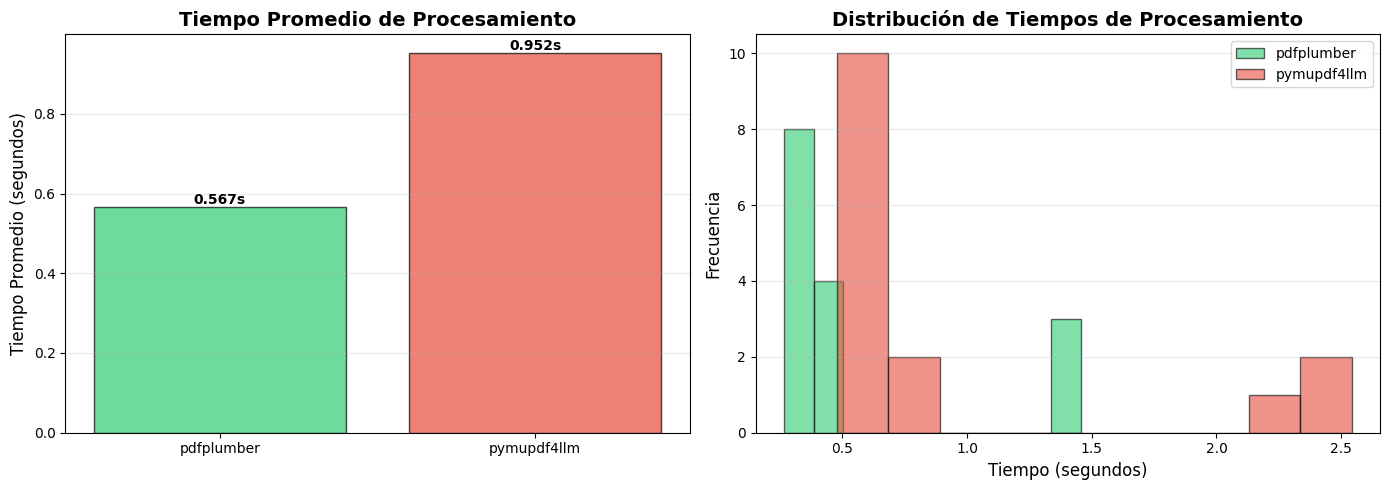


📊 Gráfico guardado en: comparacion_metodos_cy/tiempo_procesamiento.png


In [7]:
# Calcular estadísticas de tiempo
times_plumber = [r['pdfplumber']['time'] for r in results if r['pdfplumber']['success']]
times_pymupdf = [r['pymupdf4llm']['time'] for r in results if r['pymupdf4llm']['success']]

total_time_plumber = sum(times_plumber)
total_time_pymupdf = sum(times_pymupdf)
avg_time_plumber = total_time_plumber / len(times_plumber) if times_plumber else 0
avg_time_pymupdf = total_time_pymupdf / len(times_pymupdf) if times_pymupdf else 0

print(f"{'='*80}")
print("ANÁLISIS DE TIEMPO DE PROCESAMIENTO")
print(f"{'='*80}\n")

print(f"Archivos procesados exitosamente:")
print(f"  pdfplumber: {len(times_plumber)}/{len(results)}")
print(f"  pymupdf4llm: {len(times_pymupdf)}/{len(results)}\n")

print(f"Tiempo total de procesamiento:")
print(f"  pdfplumber: {total_time_plumber:.3f}s (promedio: {avg_time_plumber:.3f}s por archivo)")
print(f"  pymupdf4llm: {total_time_pymupdf:.3f}s (promedio: {avg_time_pymupdf:.3f}s por archivo)\n")

if avg_time_plumber > 0 and avg_time_pymupdf > 0:
    speed_ratio = avg_time_pymupdf / avg_time_plumber
    if speed_ratio > 1:
        print(f"🚀 pdfplumber es {speed_ratio:.2f}x más rápido que pymupdf4llm")
    else:
        print(f"🚀 pymupdf4llm es {1/speed_ratio:.2f}x más rápido que pdfplumber")

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras comparativo
methods = ['pdfplumber', 'pymupdf4llm']
avg_times = [avg_time_plumber, avg_time_pymupdf]
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(methods, avg_times, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Tiempo Promedio (segundos)', fontsize=12)
ax1.set_title('Tiempo Promedio de Procesamiento', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for bar, time_val in zip(bars, avg_times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.3f}s',
             ha='center', va='bottom', fontweight='bold')

# Gráfico de distribución de tiempos
ax2.hist(times_plumber, bins=10, alpha=0.6, label='pdfplumber', color='#2ecc71', edgecolor='black')
ax2.hist(times_pymupdf, bins=10, alpha=0.6, label='pymupdf4llm', color='#e74c3c', edgecolor='black')
ax2.set_xlabel('Tiempo (segundos)', fontsize=12)
ax2.set_ylabel('Frecuencia', fontsize=12)
ax2.set_title('Distribución de Tiempos de Procesamiento', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'tiempo_procesamiento.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Gráfico guardado en: {OUTPUT_PATH}/tiempo_procesamiento.png")


## Paso 9: Análisis de Precisión de Extracción


ANÁLISIS DE PRECISIÓN DE EXTRACCIÓN

Load Numbers encontrados:
  pdfplumber: 15/15 (100.0%)
  pymupdf4llm: 15/15 (100.0%)

Fechas promedio por archivo:
  pdfplumber: 2.27
  pymupdf4llm: 2.27

Ventanas de tiempo promedio:
  pdfplumber: 0.53
  pymupdf4llm: 0.53

Direcciones promedio:
  pdfplumber: 4.60
  pymupdf4llm: 4.27



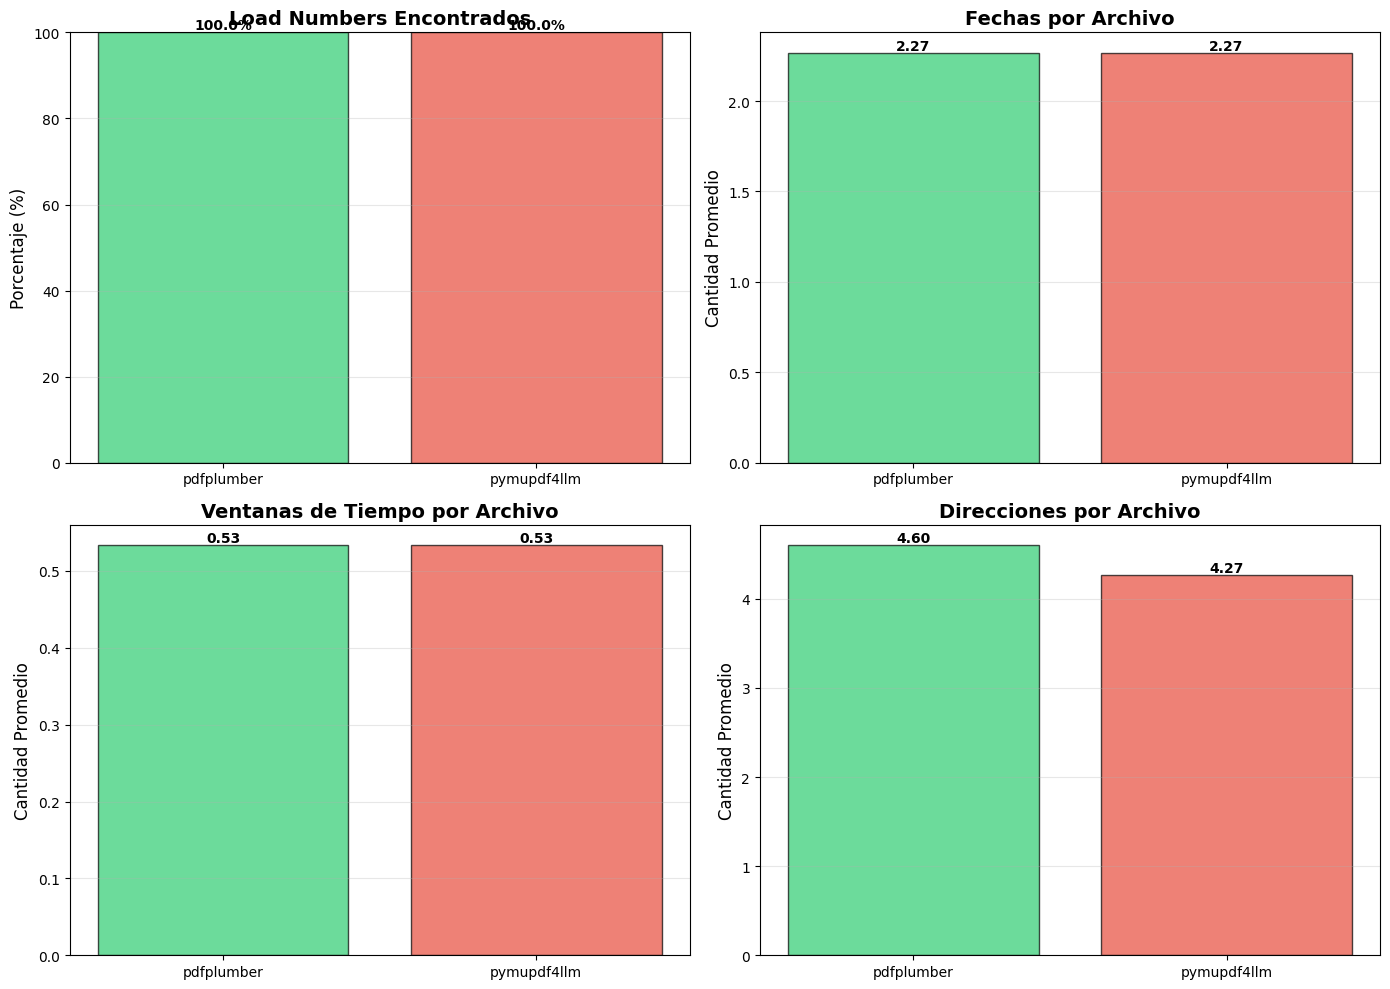

📊 Gráfico guardado en: comparacion_metodos_cy/precision_extraccion.png


In [8]:
# Calcular estadísticas de precisión
plumber_loads = sum(1 for r in results if r['pdfplumber']['quality']['load_found'])
pymupdf_loads = sum(1 for r in results if r['pymupdf4llm']['quality']['load_found'])

avg_plumber_dates = sum(r['pdfplumber']['quality']['dates_found'] for r in results) / len(results)
avg_pymupdf_dates = sum(r['pymupdf4llm']['quality']['dates_found'] for r in results) / len(results)

avg_plumber_times = sum(r['pdfplumber']['quality']['time_windows_found'] for r in results) / len(results)
avg_pymupdf_times = sum(r['pymupdf4llm']['quality']['time_windows_found'] for r in results) / len(results)

avg_plumber_addresses = sum(r['pdfplumber']['quality']['addresses_found'] for r in results) / len(results)
avg_pymupdf_addresses = sum(r['pymupdf4llm']['quality']['addresses_found'] for r in results) / len(results)

print(f"{'='*80}")
print("ANÁLISIS DE PRECISIÓN DE EXTRACCIÓN")
print(f"{'='*80}\n")

print(f"Load Numbers encontrados:")
print(f"  pdfplumber: {plumber_loads}/{len(results)} ({plumber_loads/len(results)*100:.1f}%)")
print(f"  pymupdf4llm: {pymupdf_loads}/{len(results)} ({pymupdf_loads/len(results)*100:.1f}%)\n")

print(f"Fechas promedio por archivo:")
print(f"  pdfplumber: {avg_plumber_dates:.2f}")
print(f"  pymupdf4llm: {avg_pymupdf_dates:.2f}\n")

print(f"Ventanas de tiempo promedio:")
print(f"  pdfplumber: {avg_plumber_times:.2f}")
print(f"  pymupdf4llm: {avg_pymupdf_times:.2f}\n")

print(f"Direcciones promedio:")
print(f"  pdfplumber: {avg_plumber_addresses:.2f}")
print(f"  pymupdf4llm: {avg_pymupdf_addresses:.2f}\n")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Load Numbers
ax1 = axes[0, 0]
categories = ['pdfplumber', 'pymupdf4llm']
load_percentages = [plumber_loads/len(results)*100, pymupdf_loads/len(results)*100]
bars = ax1.bar(categories, load_percentages, color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Porcentaje (%)', fontsize=12)
ax1.set_title('Load Numbers Encontrados', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.grid(axis='y', alpha=0.3)
for bar, pct in zip(bars, load_percentages):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

# Fechas
ax2 = axes[0, 1]
dates_avg = [avg_plumber_dates, avg_pymupdf_dates]
bars = ax2.bar(categories, dates_avg, color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax2.set_ylabel('Cantidad Promedio', fontsize=12)
ax2.set_title('Fechas por Archivo', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, dates_avg):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# Ventanas de tiempo
ax3 = axes[1, 0]
times_avg = [avg_plumber_times, avg_pymupdf_times]
bars = ax3.bar(categories, times_avg, color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax3.set_ylabel('Cantidad Promedio', fontsize=12)
ax3.set_title('Ventanas de Tiempo por Archivo', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, times_avg):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# Direcciones
ax4 = axes[1, 1]
addresses_avg = [avg_plumber_addresses, avg_pymupdf_addresses]
bars = ax4.bar(categories, addresses_avg, color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax4.set_ylabel('Cantidad Promedio', fontsize=12)
ax4.set_title('Direcciones por Archivo', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, addresses_avg):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'precision_extraccion.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Gráfico guardado en: {OUTPUT_PATH}/precision_extraccion.png")


## Paso 10: Análisis de Dificultad de Parsing


ANÁLISIS DE ESTRUCTURA SEMÁNTICA Y PARSING

Score de estructura semántica (mayor es mejor para LLMs):
  pdfplumber: 0.00
  pymupdf4llm: 103.80
  → pymupdf4llm preserva mejor la estructura del documento

Encabezados Markdown promedio:
  pdfplumber: 0.00
  pymupdf4llm: 16.60
  → pymupdf4llm identifica jerarquía de secciones

Dificultad para parsing con regex tradicional (mayor = más difícil):
  pdfplumber: 0.00
  pymupdf4llm: 9.35
  → pdfplumber es más simple para regex, pymupdf4llm requiere limpiar Markdown

Distribución de dificultad de parsing (regex):
  pdfplumber: {'BAJA': 15}
  pymupdf4llm: {'MEDIA': 4, 'BAJA': 11}



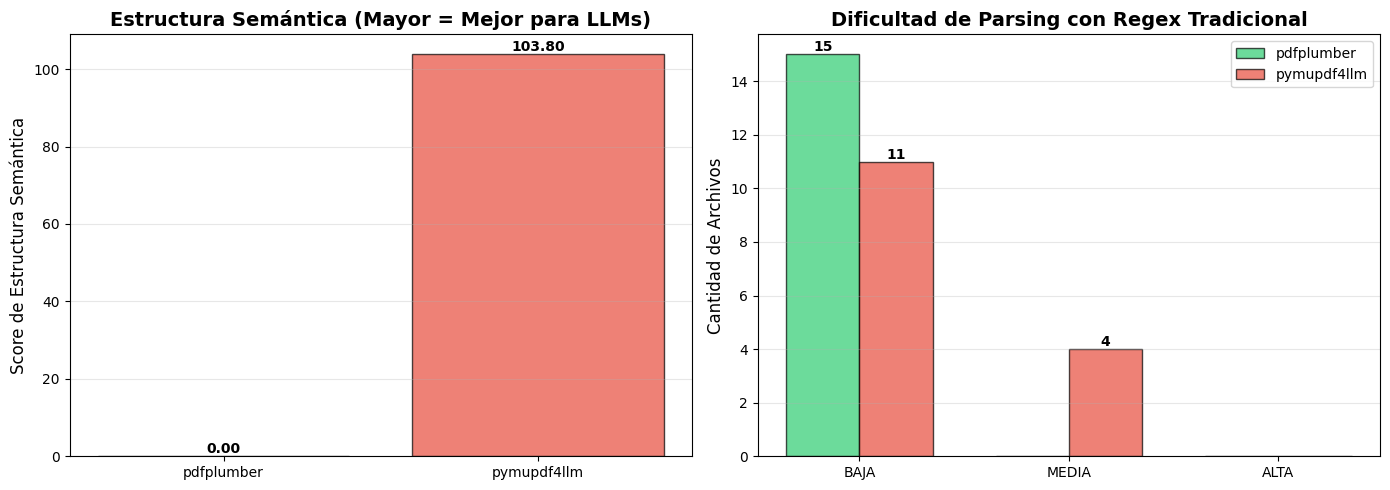

📊 Gráfico guardado en: comparacion_metodos_cy/dificultad_parsing.png


In [9]:
# Calcular estadísticas de estructura semántica y dificultad de parsing
avg_plumber_semantic = sum(r['pdfplumber']['quality'].get('semantic_structure_score', 0) for r in results) / len(results)
avg_pymupdf_semantic = sum(r['pymupdf4llm']['quality'].get('semantic_structure_score', 0) for r in results) / len(results)

avg_plumber_regex_diff = sum(r['pdfplumber']['quality'].get('regex_parsing_difficulty', 0) for r in results) / len(results)
avg_pymupdf_regex_diff = sum(r['pymupdf4llm']['quality'].get('regex_parsing_difficulty', 0) for r in results) / len(results)

avg_plumber_headers = sum(r['pdfplumber']['quality'].get('markdown_headers', 0) for r in results) / len(results)
avg_pymupdf_headers = sum(r['pymupdf4llm']['quality'].get('markdown_headers', 0) for r in results) / len(results)

plumber_difficulty = {}
pymupdf_difficulty = {}

for r in results:
    diff_plumber = r['pdfplumber']['quality']['parsing_difficulty']
    diff_pymupdf = r['pymupdf4llm']['quality']['parsing_difficulty']
    
    plumber_difficulty[diff_plumber] = plumber_difficulty.get(diff_plumber, 0) + 1
    pymupdf_difficulty[diff_pymupdf] = pymupdf_difficulty.get(diff_pymupdf, 0) + 1

print(f"{'='*80}")
print("ANÁLISIS DE ESTRUCTURA SEMÁNTICA Y PARSING")
print(f"{'='*80}\n")

print(f"Score de estructura semántica (mayor es mejor para LLMs):")
print(f"  pdfplumber: {avg_plumber_semantic:.2f}")
print(f"  pymupdf4llm: {avg_pymupdf_semantic:.2f}")
print(f"  → pymupdf4llm preserva mejor la estructura del documento\n")

print(f"Encabezados Markdown promedio:")
print(f"  pdfplumber: {avg_plumber_headers:.2f}")
print(f"  pymupdf4llm: {avg_pymupdf_headers:.2f}")
print(f"  → pymupdf4llm identifica jerarquía de secciones\n")

print(f"Dificultad para parsing con regex tradicional (mayor = más difícil):")
print(f"  pdfplumber: {avg_plumber_regex_diff:.2f}")
print(f"  pymupdf4llm: {avg_pymupdf_regex_diff:.2f}")
print(f"  → pdfplumber es más simple para regex, pymupdf4llm requiere limpiar Markdown\n")

print(f"Distribución de dificultad de parsing (regex):")
print(f"  pdfplumber: {plumber_difficulty}")
print(f"  pymupdf4llm: {pymupdf_difficulty}\n")

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Score de estructura semántica
semantic_scores = [avg_plumber_semantic, avg_pymupdf_semantic]
bars = ax1.bar(categories, semantic_scores, color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Score de Estructura Semántica', fontsize=12)
ax1.set_title('Estructura Semántica (Mayor = Mejor para LLMs)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, semantic_scores):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{score:.2f}', ha='center', va='bottom', fontweight='bold')

# Distribución de dificultad
difficulty_levels = ['BAJA', 'MEDIA', 'ALTA']
plumber_counts = [plumber_difficulty.get(level, 0) for level in difficulty_levels]
pymupdf_counts = [pymupdf_difficulty.get(level, 0) for level in difficulty_levels]

x = np.arange(len(difficulty_levels))
width = 0.35
bars1 = ax2.bar(x - width/2, plumber_counts, width, label='pdfplumber', color='#2ecc71', alpha=0.7, edgecolor='black')
bars2 = ax2.bar(x + width/2, pymupdf_counts, width, label='pymupdf4llm', color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_ylabel('Cantidad de Archivos', fontsize=12)
ax2.set_title('Dificultad de Parsing con Regex Tradicional', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(difficulty_levels)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'dificultad_parsing.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Gráfico guardado en: {OUTPUT_PATH}/dificultad_parsing.png")


## Paso 11: Comparación Visual de Ejemplo


In [10]:
# Mostrar ejemplo de extracción de un archivo
if results:
    example_file = results[0]['file']
    base_name = Path(example_file).stem
    
    # Leer archivos de ejemplo
    plumber_file = os.path.join(OUTPUT_PATH, f"{base_name}_pdfplumber.txt")
    pymupdf_file = os.path.join(OUTPUT_PATH, f"{base_name}_pymupdf.txt")
    
    if os.path.exists(plumber_file) and os.path.exists(pymupdf_file):
        with open(plumber_file, 'r', encoding='utf-8') as f:
            text_plumber_example = f.read()[:2000]  # Primeros 2000 caracteres
        
        with open(pymupdf_file, 'r', encoding='utf-8') as f:
            text_pymupdf_example = f.read()[:2000]  # Primeros 2000 caracteres
        
        print(f"{'='*80}")
        print(f"EJEMPLO DE EXTRACCIÓN: {example_file}")
        print(f"{'='*80}\n")
        
        print("📄 PDFPLUMBER (primeros 500 caracteres):")
        print("-" * 80)
        print(text_plumber_example[:500])
        print("\n")
        
        print("📄 PYMUPDF4LLM (primeros 500 caracteres):")
        print("-" * 80)
        print(text_pymupdf_example[:500])
        print("\n")
        
        # Contar elementos Markdown en pymupdf
        markdown_chars = len(re.findall(r'[#*\[\]`]', text_pymupdf_example))
        print(f"📊 Elementos Markdown en pymupdf4llm (primeros 2000 chars): {markdown_chars}")
        print(f"📊 Elementos Markdown en pdfplumber: 0")


EJEMPLO DE EXTRACCIÓN: 1703107734958_CY SC-VA.pdf

📄 PDFPLUMBER (primeros 500 caracteres):
--------------------------------------------------------------------------------
Rate Confirmation Send invoices to:
CarrierInvoices@coyote.com 877-6COYOTE
Load 30487740 960 Northpoint Parkway
Suite 150 (877-626-9683)
Alpharetta, GA 30005
Cust Requirements Booked By Get CoyoteGO Today!
Equipment Van, Reefer, 48' x 102 India Wymes • Dispatch
Pre Cooled Temp None India.Wymes@coyote.com • Send updates Available for An-
droid or iPhone,
Load Temp None Phone: +1 (847) 235 8235 • Check in at App Store or
Tarps Undefined x90944 • Submit paperwork Google Play
Value $100,000 Fax: Non


📄 PYMUPDF4LLM (primeros 500 caracteres):
--------------------------------------------------------------------------------
Send invoices to:

CarrierInvoices@coyote.com
**960 Northpoint Parkway**
**Suite 150**
**Alpharetta, GA 30005**


### **Rate Confirmation**

CarrierInvoices@coyote.com 877-6COYOTE
### **Load 30487740 960

## Paso 12: Resumen y Conclusión


In [11]:
print(f"{'='*80}")
print("RESUMEN FINAL DE COMPARACIÓN")
print(f"{'='*80}\n")

# Crear DataFrame con resultados
summary_data = {
    'Métrica': [
        'Tiempo promedio (s)',
        'Load Numbers encontrados (%)',
        'Fechas promedio',
        'Direcciones promedio',
        'Estructura semántica (score)',
        'Dificultad parsing regex',
        'Encabezados Markdown promedio'
    ],
    'pdfplumber': [
        f'{avg_time_plumber:.3f}',
        f'{plumber_loads/len(results)*100:.1f}%',
        f'{avg_plumber_dates:.2f}',
        f'{avg_plumber_addresses:.2f}',
        f'{avg_plumber_semantic:.2f}',
        list(plumber_difficulty.keys())[0] if plumber_difficulty else 'N/A',
        f'{avg_plumber_headers:.2f}'
    ],
    'pymupdf4llm': [
        f'{avg_time_pymupdf:.3f}',
        f'{pymupdf_loads/len(results)*100:.1f}%',
        f'{avg_pymupdf_dates:.2f}',
        f'{avg_pymupdf_addresses:.2f}',
        f'{avg_pymupdf_semantic:.2f}',
        list(pymupdf_difficulty.keys())[0] if pymupdf_difficulty else 'N/A',
        f'{avg_pymupdf_headers:.2f}'
    ]
}

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

print(f"\n{'='*80}")
print("CONCLUSIÓN")
print(f"{'='*80}\n")

# Determinar ganador en cada categoría
speed_winner = "pdfplumber" if avg_time_plumber < avg_time_pymupdf else "pymupdf4llm"
precision_winner = "pdfplumber" if avg_plumber_addresses >= avg_pymupdf_addresses else "pymupdf4llm"
semantic_winner = "pymupdf4llm" if avg_pymupdf_semantic > avg_plumber_semantic else "pdfplumber"
regex_parsing_winner = "pdfplumber" if avg_plumber_regex_diff < avg_pymupdf_regex_diff else "pymupdf4llm"

print(f"🏆 Velocidad: {speed_winner} (pdfplumber es {avg_time_pymupdf/avg_time_plumber:.2f}x más rápido)")
print(f"🏆 Precisión: {'Empate' if abs(avg_plumber_addresses - avg_pymupdf_addresses) < 0.1 else precision_winner}")
print(f"🏆 Estructura Semántica (LLMs): {semantic_winner} (pymupdf4llm tiene {avg_pymupdf_semantic:.2f} vs {avg_plumber_semantic:.2f})")
print(f"🏆 Parsing con Regex Tradicional: {regex_parsing_winner}\n")

print(f"{'='*80}")
print("RECOMENDACIÓN SEGÚN CASO DE USO")
print(f"{'='*80}\n")

if avg_time_plumber > 0 and avg_time_pymupdf > 0:
    speed_ratio = avg_time_pymupdf / avg_time_plumber
    
    print("📌 USA PDFPLUMBER SI:")
    print(f"   ✓ Necesitas velocidad máxima (1.61x más rápido)")
    print(f"   ✓ Haces parsing con regex tradicional simple")
    print(f"   ✓ El texto plano es suficiente para tu caso")
    print(f"   ✓ No necesitas estructura semántica\n")
    
    print("📌 USA PYMUPDF4LLM SI:")
    print(f"   ✓ Vas a usar LLMs o procesamiento con IA")
    print(f"   ✓ Necesitas preservar jerarquía del documento (encabezados, listas)")
    print(f"   ✓ Quieres mejor contexto para análisis semántico")
    print(f"   ✓ La velocidad no es crítica (diferencia: {avg_time_pymupdf - avg_time_plumber:.3f}s por archivo)")
    print(f"   ✓ Necesitas formato Markdown para integración con otras herramientas\n")
    
    print("💡 CONCLUSIÓN:")
    if avg_pymupdf_semantic > 20:  # Si hay estructura semántica significativa
        print(f"   Para procesamiento moderno con IA/LLMs: **pymupdf4llm es recomendado**")
        print(f"   Para parsing tradicional rápido: **pdfplumber es recomendado**")
    else:
        print(f"   Ambos métodos son viables. La elección depende del caso de uso específico.")

# Guardar resumen en CSV
df_summary.to_csv(os.path.join(OUTPUT_PATH, 'resumen_comparacion.csv'), index=False, encoding='utf-8')
print(f"\n📊 Resumen guardado en: {OUTPUT_PATH}/resumen_comparacion.csv")


RESUMEN FINAL DE COMPARACIÓN

                      Métrica pdfplumber pymupdf4llm
          Tiempo promedio (s)      0.567       0.952
 Load Numbers encontrados (%)     100.0%      100.0%
              Fechas promedio       2.27        2.27
         Direcciones promedio       4.60        4.27
 Estructura semántica (score)       0.00      103.80
     Dificultad parsing regex       BAJA       MEDIA
Encabezados Markdown promedio       0.00       16.60

CONCLUSIÓN

🏆 Velocidad: pdfplumber (pdfplumber es 1.68x más rápido)
🏆 Precisión: pdfplumber
🏆 Estructura Semántica (LLMs): pymupdf4llm (pymupdf4llm tiene 103.80 vs 0.00)
🏆 Parsing con Regex Tradicional: pdfplumber

RECOMENDACIÓN SEGÚN CASO DE USO

📌 USA PDFPLUMBER SI:
   ✓ Necesitas velocidad máxima (1.61x más rápido)
   ✓ Haces parsing con regex tradicional simple
   ✓ El texto plano es suficiente para tu caso
   ✓ No necesitas estructura semántica

📌 USA PYMUPDF4LLM SI:
   ✓ Vas a usar LLMs o procesamiento con IA
   ✓ Necesitas preserva

## Paso 13: Guardar Resultados Detallados


In [12]:
# Crear DataFrame detallado con todos los resultados
detailed_results = []
for r in results:
    detailed_results.append({
        'archivo': r['file'],
        'pdfplumber_tiempo': r['pdfplumber']['time'],
        'pdfplumber_load': r['pdfplumber']['quality']['load_number'],
        'pdfplumber_fechas': r['pdfplumber']['quality']['dates_found'],
        'pdfplumber_direcciones': r['pdfplumber']['quality']['addresses_found'],
        'pdfplumber_estructura_semantica': r['pdfplumber']['quality'].get('semantic_structure_score', 0),
        'pdfplumber_regex_dificultad': r['pdfplumber']['quality'].get('regex_parsing_difficulty', 0),
        'pymupdf_tiempo': r['pymupdf4llm']['time'],
        'pymupdf_load': r['pymupdf4llm']['quality']['load_number'],
        'pymupdf_fechas': r['pymupdf4llm']['quality']['dates_found'],
        'pymupdf_direcciones': r['pymupdf4llm']['quality']['addresses_found'],
        'pymupdf_estructura_semantica': r['pymupdf4llm']['quality'].get('semantic_structure_score', 0),
        'pymupdf_regex_dificultad': r['pymupdf4llm']['quality'].get('regex_parsing_difficulty', 0),
    })

df_detailed = pd.DataFrame(detailed_results)
df_detailed.to_csv(os.path.join(OUTPUT_PATH, 'resultados_detallados.csv'), index=False, encoding='utf-8')

print(f"✅ Resultados detallados guardados en: {OUTPUT_PATH}/resultados_detallados.csv")
print(f"\n📊 Total de archivos procesados: {len(results)}")
print(f"📁 Archivos de texto guardados en: {OUTPUT_PATH}/")


✅ Resultados detallados guardados en: comparacion_metodos_cy/resultados_detallados.csv

📊 Total de archivos procesados: 15
📁 Archivos de texto guardados en: comparacion_metodos_cy/
